In [262]:

import cv2
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, 
    Activation, Add,AveragePooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score, roc_curve, auc, recall_score, average_precision_score
from tensorflow.keras.models import load_model
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



In [2]:
parent_folder_path = 'tapescans_for_thomas'

folder840_image_paths = []
folder1122_image_paths = []
folder1190_image_paths = []
folder1440_image_paths = []
folder1765_image_paths = []

max_images_to_collect = 220

subfolder_names = ['840', '1122', '1190', '1440', '1765']

for subfolder_name, image_paths_list in zip(subfolder_names, [
    folder840_image_paths,
    folder1122_image_paths,
    folder1190_image_paths,
    folder1440_image_paths,
    folder1765_image_paths
]):
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)

    for root, _, files in os.walk(subfolder_path):
        for file in files:
            if len(image_paths_list) >= max_images_to_collect:
                break  # Stop if we've collected the maximum number of image paths
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths_list.append(os.path.join(root, file))
                
image_paths=folder1440_image_paths

In [3]:
# Load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to desired input size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

images = [load_and_preprocess_image(image_path) for image_path in image_paths]

In [4]:
# Load the CSV file with bounding box coordinates
csv_file = "rust_predictions_for_thomas.csv"
data = pd.read_csv(csv_file)

# Create labels
labels = np.array(data[['x_min', 'x_max', 'y_min', 'y_max','image_file_key']])
for i in range(len(labels)):
    labels[i][4]='tapescans_for_thomas\\'+labels[i][4].replace('/','\\')

In [5]:
def associate_images_with_bboxes(image_paths, labels):
    image_bbox_mapping = {}

    # Initialize the mapping
    for image_path in image_paths:
        image_bbox_mapping[image_path] = []

    # Iterate through labels and associate bounding boxes with images
    for label in labels:
        image_file_key = label[-1]  # Assuming the image file key is in the last column
        if image_file_key in image_bbox_mapping:
            image_bbox_mapping[image_file_key].append(label[:-1])  # Exclude the image file key

    # Convert the mapping to a list of lists
    result = [image_bbox_mapping[image_path] for image_path in image_paths]

    return result

associated_bboxes = associate_images_with_bboxes(image_paths, labels)


In [6]:
def display_image_with_bounding_boxes(image_path, bounding_boxes):
    # Load the image using the provided image_path
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bounding_boxes:
        x_min, x_max, y_min, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='g', facecolor='none'
        )

        # Add the rectangle to the axes
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()




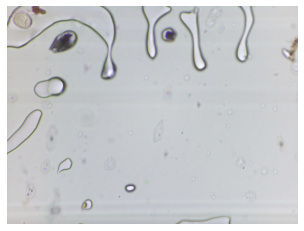

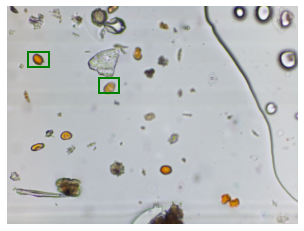

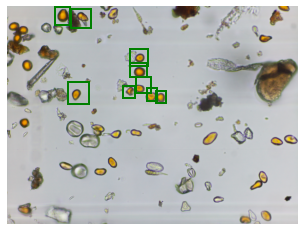

In [7]:
# Call the function to display an image with its bounding boxes
display_image_with_bounding_boxes(image_paths[1], associated_bboxes[1])
display_image_with_bounding_boxes(image_paths[3], associated_bboxes[3])
display_image_with_bounding_boxes(image_paths[4], associated_bboxes[4])

In [8]:
# Label Encoding 
def create_masks(associated_bboxes, image_paths, target_size=(224, 224)):
    masks = []

    for image_bboxes, image_path in zip(associated_bboxes, image_paths):
        # Load the image to get its original size
        original_image = cv2.imread(image_path)
        original_height, original_width, _ = original_image.shape

        target_width, target_height = target_size

        width_ratio = target_width / original_width
        height_ratio = target_height / original_height

        mask = np.zeros(target_size, dtype=np.uint8)

        for bbox in image_bboxes:
            x_min, x_max, y_min, y_max = bbox

            # Adjust the coordinates to match the target size
            x_min = int(x_min * width_ratio)
            x_max = int(x_max * width_ratio)
            y_min = int(y_min * height_ratio)
            y_max = int(y_max * height_ratio)

            mask[y_min:y_max, x_min:x_max] = 1

        masks.append(mask)

    return masks

masks=create_masks(associated_bboxes, image_paths, target_size=(224, 224))

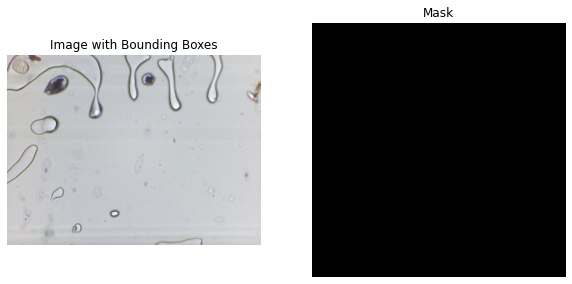

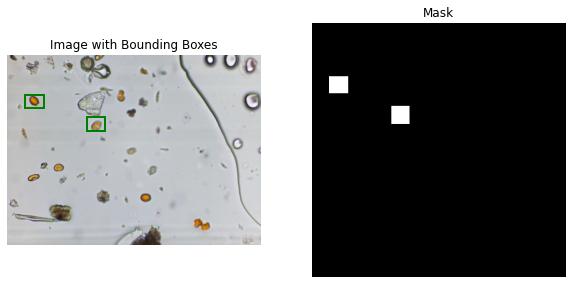

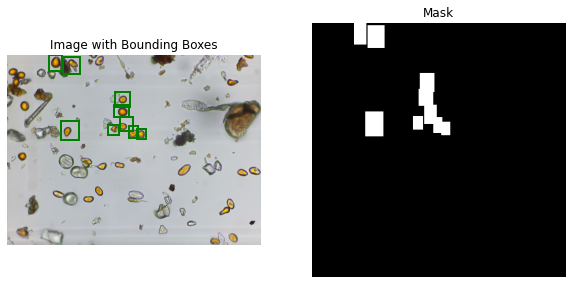

In [9]:
#function to display the image with the bounding boxes next to their associated masks
def display_image_with_masks(image_path, bounding_boxes, mask):
    # Load the image using the provided image_path
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure and axes
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image with bounding boxes on the first subplot
    ax[0].imshow(image)

    for bbox in bounding_boxes:
        x_min, x_max, y_min, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='g', facecolor='none'
        )

        # Add the rectangle to the first subplot
        ax[0].add_patch(rect)

    ax[0].set_title('Image with Bounding Boxes')
    ax[0].axis('off')

    # Display the mask with white pixels for ones and black pixels for zeros on the second subplot
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

display_image_with_masks(image_paths[1], associated_bboxes[1],masks[1])
display_image_with_masks(image_paths[3], associated_bboxes[3],masks[3])
display_image_with_masks(image_paths[4], associated_bboxes[4],masks[4])


In [10]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test))

(176, 224, 224, 3) (176, 224, 224) (44, 224, 224, 3) (44, 224, 224)


In [11]:
# Define a custom metric for Mean Average Precision for binary classification
class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, name='mean_average_precision', **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.auc_metric = AUC(name='mAP', curve='PR')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.auc_metric.update_state(y_true, y_pred)

    def result(self):
        return self.auc_metric.result()

    def reset_states(self):
        self.auc_metric.reset_state()

In [268]:
# Define the U-Net model
def unet_model(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Additional Encoder Layers
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)


    # Bottleneck
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.Conv2D(64, 2, activation='relu', padding='same')(up1)
    merge1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)

    # Additional Decoder Layers
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.Conv2D(32, 2, activation='relu', padding='same')(up2)
    merge2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge2)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)  # Output mask with a single channel

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Create the U-Net model
unet_model = unet_model()

# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', 
                       metrics=['accuracy', tf.keras.metrics.Recall(), MeanAveragePrecision()])

# Print model summary
unet_model.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_110 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2282 (Conv2D)            (None, 224, 224, 32) 896         input_110[0][0]                  
__________________________________________________________________________________________________
conv2d_2283 (Conv2D)            (None, 224, 224, 32) 9248        conv2d_2282[0][0]                
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_2283[0][0]                
___________________________________________________________________________________________

In [269]:
# Train the U-Net model
epochs = 20
batch_size = 16

unet_history = unet_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                  epochs=epochs, batch_size=batch_size)


Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9848 - recall_28: 0.0000e+00 - mean_average_precision: 0.0161

C:\Users\thoma\anaconda3\lib\site-packages\keras\metrics.py:254: UserWarning: Metric MeanAveragePrecision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


11/11 [==============================] - 93s 8s/step - loss: 0.2171 - accuracy: 0.9848 - recall_28: 0.0000e+00 - mean_average_precision: 0.0161 - val_loss: 0.0739 - val_accuracy: 0.9857 - val_recall_28: 0.0000e+00 - val_mean_average_precision: 0.0611
Epoch 2/20
11/11 [==============================] - 92s 8s/step - loss: 0.0716 - accuracy: 0.9848 - recall_28: 0.0000e+00 - mean_average_precision: 0.0591 - val_loss: 0.0662 - val_accuracy: 0.9857 - val_recall_28: 0.0000e+00 - val_mean_average_precision: 0.0707
Epoch 3/20
11/11 [==============================] - 93s 8s/step - loss: 0.0658 - accuracy: 0.9848 - recall_28: 0.0000e+00 - mean_average_precision: 0.0890 - val_loss: 0.0608 - val_accuracy: 0.9857 - val_recall_28: 0.0000e+00 - val_mean_average_precision: 0.1027
Epoch 4/20
11/11 [==============================] - 93s 9s/step - loss: 0.0614 - accuracy: 0.9848 - recall_28: 0.0036 - mean_average_precision: 0.1409 - val_loss: 0.0592 - val_accuracy: 0.9861 - val_recall_28: 0.0537 - val_me

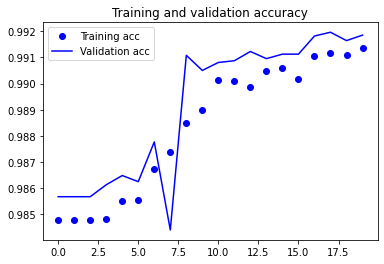

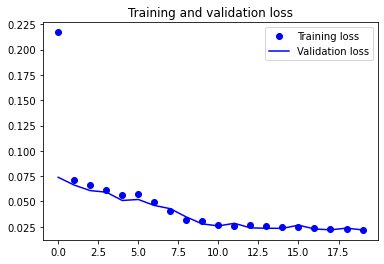

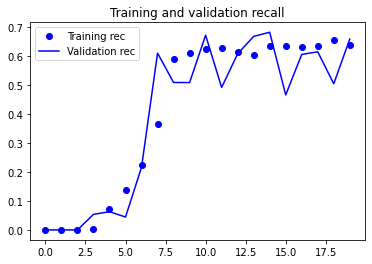

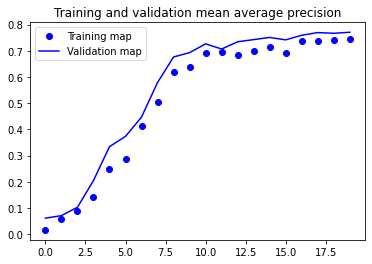

In [271]:
#This code is used to plot the loss function, accuracy, recall and mean average precision
#for training and validation data during the learning phase. 

acc = unet_history.history['accuracy']
val_acc = unet_history.history['val_accuracy']
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
rec = unet_history.history['recall_28']
val_rec = unet_history.history['val_recall_28']
m_a_p = unet_history.history['mean_average_precision']
val_m_a_p = unet_history.history['val_mean_average_precision']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, rec, 'bo', label='Training rec')
plt.plot(epochs, val_rec, 'b', label='Validation rec')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, m_a_p, 'bo', label='Training map')
plt.plot(epochs, val_m_a_p, 'b', label='Validation map')
plt.title('Training and validation mean average precision')
plt.legend()

plt.show()

In [16]:
# Evaluate the model on the test data
loss, accuracy, recall, mean_average_precision = unet_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

2/2 [==============================] - 5s 1s/step - loss: 0.0233 - accuracy: 0.9914 - recall: 0.5538 - mean_average_precision: 0.7446
Test accuracy: 0.9914197325706482


In [35]:
# Define the FCN model
def fcn_model(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.Conv2D(64, 2, activation='relu', padding='same')(up1)
    merge1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.Conv2D(32, 2, activation='relu', padding='same')(up2)
    merge2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge2)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)

    # Output layer with softmax activation for multi-class segmentation
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)  

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create the FCN model
fcn_model = fcn_model()

# Compile the model
fcn_model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Recall(),MeanAveragePrecision()])
# Print model summary
fcn_model.summary()



Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 224, 224, 32) 896         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_129[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_130[0][0]                 
____________________________________________________________________________________________

In [36]:
# Train the FCN model
epochs = 15
batch_size = 16

fcn_history = fcn_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                epochs=epochs, batch_size=batch_size)

Epoch 1/20
11/11 [==============================] - 91s 8s/step - loss: 0.3757 - accuracy: 0.8969 - recall_7: 0.0811 - mean_average_precision: 0.0163 - val_loss: 0.0800 - val_accuracy: 0.9857 - val_recall_7: 0.0000e+00 - val_mean_average_precision: 0.0260
Epoch 2/20
11/11 [==============================] - 91s 8s/step - loss: 0.0924 - accuracy: 0.9848 - recall_7: 0.0000e+00 - mean_average_precision: 0.0179 - val_loss: 0.0744 - val_accuracy: 0.9857 - val_recall_7: 0.0000e+00 - val_mean_average_precision: 0.0416
Epoch 3/20
11/11 [==============================] - 96s 9s/step - loss: 0.0762 - accuracy: 0.9848 - recall_7: 0.0000e+00 - mean_average_precision: 0.0396 - val_loss: 0.0693 - val_accuracy: 0.9857 - val_recall_7: 0.0000e+00 - val_mean_average_precision: 0.0669
Epoch 4/20
11/11 [==============================] - 90s 8s/step - loss: 0.0672 - accuracy: 0.9848 - recall_7: 0.0000e+00 - mean_average_precision: 0.0792 - val_loss: 0.0585 - val_accuracy: 0.9857 - val_recall_7: 0.0000e+00 -

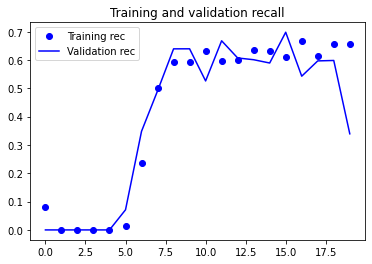

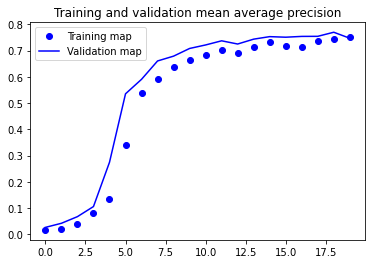

In [57]:
#This code is used to plot the loss function, accuracy, recall and mean average precision
#for training and validation data during the learning phase. 

acc = fcn_history.history['accuracy']
val_acc = fcn_history.history['val_accuracy']
loss = fcn_history.history['loss']
val_loss = fcn_history.history['val_loss']
rec = fcn_history.history['recall_7']
val_rec = fcn_history.history['val_recall_7']
m_a_p = fcn_history.history['mean_average_precision']
val_m_a_p = fcn_history.history['val_mean_average_precision']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, rec, 'bo', label='Training rec')
plt.plot(epochs, val_rec, 'b', label='Validation rec')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, m_a_p, 'bo', label='Training map')
plt.plot(epochs, val_m_a_p, 'b', label='Validation map')
plt.title('Training and validation mean average precision')
plt.legend()

plt.show()

In [51]:
def segnet_model(input_shape=(224, 224, 3)):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)

    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv2)

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(pool2)
    up2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

    up1 = layers.UpSampling2D(size=(2, 2))(up2)
    up1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up1)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Create the SegNet model
segnet_model = segnet_model()

# Compile the model
segnet_model.compile(optimizer='adam', loss='binary_crossentropy', 
                         metrics=['accuracy', tf.keras.metrics.Recall(),MeanAveragePrecision()])

# Print model summary
segnet_model.summary()





Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 64)        0  

In [52]:
# Train the segnet model
epochs = 15
batch_size = 16

segnet_history = segnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                      epochs=epochs, batch_size=batch_size)

Epoch 1/20
11/11 [==============================] - 111s 10s/step - loss: 0.2411 - accuracy: 0.9836 - recall_11: 2.6037e-04 - mean_average_precision: 0.0143 - val_loss: 0.0762 - val_accuracy: 0.9857 - val_recall_11: 0.0000e+00 - val_mean_average_precision: 0.0351
Epoch 2/20
11/11 [==============================] - 108s 10s/step - loss: 0.0871 - accuracy: 0.9848 - recall_11: 0.0000e+00 - mean_average_precision: 0.0198 - val_loss: 0.0752 - val_accuracy: 0.9857 - val_recall_11: 0.0000e+00 - val_mean_average_precision: 0.0366
Epoch 3/20
11/11 [==============================] - 108s 10s/step - loss: 0.0805 - accuracy: 0.9848 - recall_11: 0.0000e+00 - mean_average_precision: 0.0249 - val_loss: 0.0694 - val_accuracy: 0.9857 - val_recall_11: 0.0000e+00 - val_mean_average_precision: 0.0591
Epoch 4/20
11/11 [==============================] - 108s 10s/step - loss: 0.0685 - accuracy: 0.9848 - recall_11: 0.0000e+00 - mean_average_precision: 0.0809 - val_loss: 0.0651 - val_accuracy: 0.9857 - val_rec

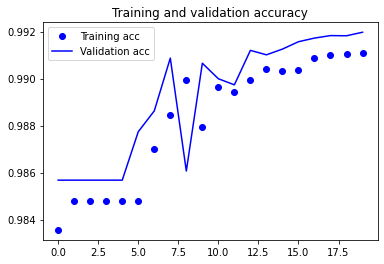

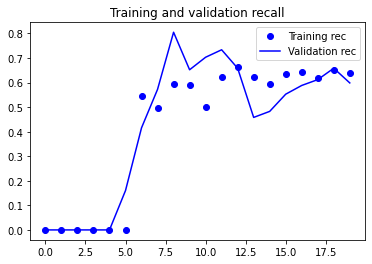

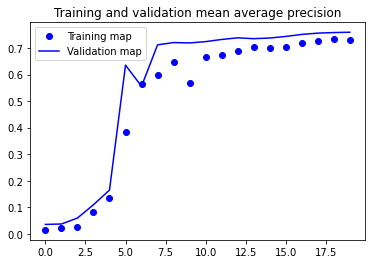

In [56]:
#This code is used to plot the loss function, accuracy, recall and mean average precision
#for training and validation data during the learning phase. 

acc = segnet_history.history['accuracy']
val_acc = segnet_history.history['val_accuracy']
loss = segnet_history.history['loss']
val_loss = segnet_history.history['val_loss']
rec = segnet_history.history['recall_11']
val_rec = segnet_history.history['val_recall_11']
m_a_p = segnet_history.history['mean_average_precision']
val_m_a_p = segnet_history.history['val_mean_average_precision']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, rec, 'bo', label='Training rec')
plt.plot(epochs, val_rec, 'b', label='Validation rec')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, m_a_p, 'bo', label='Training map')
plt.plot(epochs, val_m_a_p, 'b', label='Validation map')
plt.title('Training and validation mean average precision')
plt.legend()

plt.show()

In [111]:
def conv_block(input_tensor, filters, kernel_size=3, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = Activation('relu')(x)
    return x

def encoder_block(input_tensor, filters):
    x = conv_block(input_tensor, filters)
    x = conv_block(x, filters)
    shortcut = Conv2D(filters, 1, strides=1, padding='same')(input_tensor)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def decoder_block(input_tensor, filters, skip_tensor):
    x = Concatenate()([input_tensor, skip_tensor])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

def LinkNet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder
    enc1 = encoder_block(inputs, 32)  
    enc2 = encoder_block(enc1, 64)  
    enc3 = encoder_block(enc2, 128)  


    # Decoder
    dec3 = decoder_block(enc3, 64, enc2)  
    dec2 = decoder_block(dec3, 32, enc1)
    dec1 = decoder_block(dec2, 16, inputs) 

    # Output
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(dec1)

    model = Model(inputs, outputs, name='linknet')

    return model


# Instantiate the LinkNet model
linknet_model = LinkNet(input_shape=(224, 224, 3))

# Compile the model 
linknet_model.compile(optimizer='adam', loss='binary_crossentropy', 
                          metrics=['accuracy', tf.keras.metrics.Recall(),MeanAveragePrecision()])

# Display the model summary
linknet_model.summary()

Model: "linknet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_466 (Conv2D)             (None, 224, 224, 32) 896         input_65[0][0]                   
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 224, 224, 32) 0           conv2d_466[0][0]                 
__________________________________________________________________________________________________
conv2d_467 (Conv2D)             (None, 224, 224, 32) 9248        activation_239[0][0]             
____________________________________________________________________________________________

In [114]:
# Train the linknet model
epochs = 20
batch_size = 16

linknet_model_history = linknet_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                              epochs=epochs, batch_size=batch_size)

Epoch 1/20
11/11 [==============================] - 320s 29s/step - loss: 0.0470 - accuracy: 0.9849 - recall_20: 0.0085 - mean_average_precision: 0.2822 - val_loss: 0.0442 - val_accuracy: 0.9874 - val_recall_20: 0.1696 - val_mean_average_precision: 0.4712
Epoch 2/20
11/11 [==============================] - 318s 29s/step - loss: 0.0372 - accuracy: 0.9872 - recall_20: 0.4265 - mean_average_precision: 0.5287 - val_loss: 0.0314 - val_accuracy: 0.9898 - val_recall_20: 0.6445 - val_mean_average_precision: 0.6582
Epoch 3/20
11/11 [==============================] - 317s 29s/step - loss: 0.0305 - accuracy: 0.9890 - recall_20: 0.6575 - mean_average_precision: 0.6477 - val_loss: 0.0286 - val_accuracy: 0.9907 - val_recall_20: 0.6140 - val_mean_average_precision: 0.6968
Epoch 4/20
11/11 [==============================] - 320s 29s/step - loss: 0.0284 - accuracy: 0.9898 - recall_20: 0.6627 - mean_average_precision: 0.6705 - val_loss: 0.0292 - val_accuracy: 0.9912 - val_recall_20: 0.5716 - val_mean_av

In [118]:
#This code is used to plot the loss function, accuracy, recall and mean average precision
#for training and validation data during the learning phase. 

acc = linknet_model_history.history['accuracy']
val_acc = linknet_model_history.history['val_accuracy']
loss = linknet_model_history.history['loss']
val_loss = linknet_model_history.history['val_loss']
rec = linknet_model_history.history['recall_20']
val_rec = linknet_model_history.history['val_recall_20']
m_a_p = linknet_model_history.history['mean_average_precision']
val_m_a_p = linknet_model_history.history['val_mean_average_precision']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, rec, 'bo', label='Training rec')
plt.plot(epochs, val_rec, 'b', label='Validation rec')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, m_a_p, 'bo', label='Training map')
plt.plot(epochs, val_m_a_p, 'b', label='Validation map')
plt.title('Training and validation mean average precision')
plt.legend()

plt.show()

In [273]:
# getting the predicted masks
unet_y_pred = unet_model.predict(X_test)
unet_y_pred=np.reshape(unet_y_pred,(44, 224, 224))

segnet_y_pred = segnet_model.predict(X_test)
segnet_y_pred=np.reshape(segnet_y_pred,(44, 224, 224))

linknet_y_pred = linknet_model.predict(X_test)
linknet_y_pred=np.reshape(linknet_y_pred,(44, 224, 224))

fcn_y_pred = fcn_model.predict(X_test)
fcn_y_pred=np.reshape(fcn_y_pred,(44, 224, 224))


# Function to find the threshold for matching the number of ones
def find_best_threshold(y_test, y_pred):
    thresholds = np.arange(0.1, 0.5, 0.001)  # Create a range of threshold values to test
    best_threshold = 0
    best_difference = 224*224

    for threshold in thresholds:
        current_difference=0
        for i in range(len(y_test)):
            predicted_ones = np.count_nonzero(y_test[i])
            y_pred_binary = (y_pred[i] > threshold).astype(int)  # Apply the threshold
            # Calculate difference of ones for the current threshold
            current_difference += np.abs(predicted_ones-np.count_nonzero(y_pred_binary))
            

        # Update the best threshold if the current difference score is higher
        if current_difference < best_difference:
            best_difference = current_difference
            best_threshold = threshold

    return best_threshold


#finding the threshold to balance the number of ones


unet_threshold = find_best_threshold(y_test,unet_y_pred)
segnet_threshold = find_best_threshold(y_test,segnet_y_pred)
linknet_threshold = find_best_threshold(y_test,linknet_y_pred)
fcn_threshold = find_best_threshold(y_test,fcn_y_pred)


# Thresholding to obtain binary masks 
for i in range(len(unet_y_pred)):
    unet_y_pred[i]=(unet_y_pred[i] > unet_threshold).astype(int)
    
for i in range(len(segnet_y_pred)):
    segnet_y_pred[i]=(segnet_y_pred[i] > segnet_threshold).astype(int)
    
for i in range(len(linknet_y_pred)):
    linknet_y_pred[i]=(linknet_y_pred[i] > linknet_threshold).astype(int)

for i in range(len(fcn_y_pred)):
    fcn_y_pred[i]=(fcn_y_pred[i] > fcn_threshold).astype(int)


Unet Precision: 0.6930447560154289
Unet Average Precision: 0.5002221198796426
Unet Recall: 0.7159029820067673
 Unet F1 Score: 0.7042884474793512
Unet Intersection over Union (IoU): 0.5435534213685475


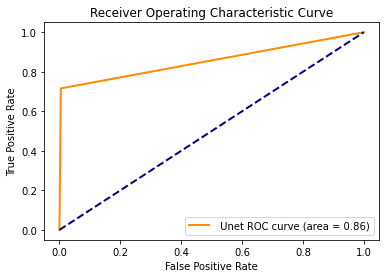

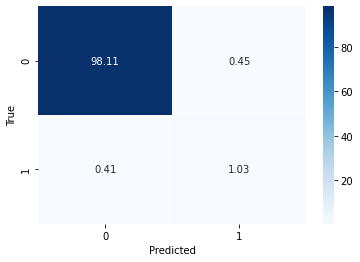

In [274]:
# Precision
unet_precision = precision_score(y_test.flatten(), unet_y_pred.flatten())
print(f'Unet Precision: {unet_precision}')

# Average Precision
unet_average_precision = average_precision_score(y_test.flatten(), unet_y_pred.flatten())
print(f'Unet Average Precision: {unet_average_precision}')

# Recall
unet_precision = recall_score(y_test.flatten(), unet_y_pred.flatten())
print(f'Unet Recall: {unet_precision}')

# F1 Score
unet_f1 = f1_score(y_test.flatten(), unet_y_pred.flatten())
print(f' Unet F1 Score: {unet_f1}')

# Intersection over Union (IoU)
unet_intersection = np.logical_and(y_test.flatten(), unet_y_pred.flatten())
unet_union = np.logical_or(y_test.flatten(), unet_y_pred.flatten())
unet_iou = np.sum(unet_intersection) / np.sum(unet_union)
print(f'Unet Intersection over Union (IoU): {unet_iou}')

# Receiver Operating Characteristic (ROC) Curve and AUC
unet_fpr, unet_tpr, unet_thresholds = roc_curve(y_test.flatten(), unet_y_pred.flatten())
unet_roc_auc = auc(unet_fpr, unet_tpr)

plt.figure()
plt.plot(unet_fpr, unet_tpr, color='darkorange', lw=2, 
             label=f' Unet ROC curve (area = {unet_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

unet_cm = confusion_matrix(y_test.flatten(), unet_y_pred.flatten())
unet_total = np.sum(unet_cm)
unet_percentages = unet_cm / unet_total * 100
sns.heatmap(unet_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

SegNet Precision: 0.703432787937119
SegNet Average Precision: 0.49212168205641765
SegNet Recall: 0.6933561015716408
SegNet F1 Score: 0.6983580972401382
SegNet Intersection over Union (IoU): 0.5365209092911151


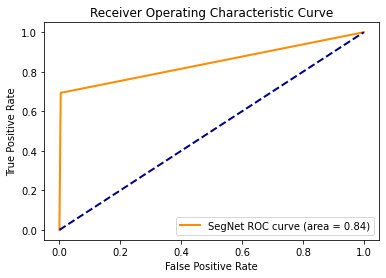

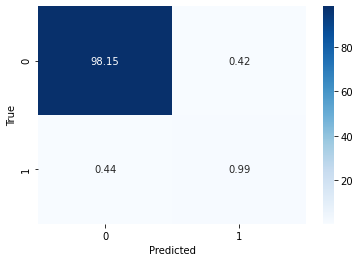

In [207]:
# Precision
segnet_precision = precision_score(y_test.flatten(), segnet_y_pred.flatten())
print(f'SegNet Precision: {segnet_precision}')

# Average Precision
segnet_average_precision = average_precision_score(y_test.flatten(), segnet_y_pred.flatten())
print(f'SegNet Average Precision: {segnet_average_precision}')

# Recall
segnet_recall = recall_score(y_test.flatten(), segnet_y_pred.flatten())
print(f'SegNet Recall: {segnet_recall}')

# F1 Score
segnet_f1 = f1_score(y_test.flatten(), segnet_y_pred.flatten())
print(f'SegNet F1 Score: {segnet_f1}')

# Intersection over Union (IoU)
segnet_intersection = np.logical_and(y_test.flatten(), segnet_y_pred.flatten())
segnet_union = np.logical_or(y_test.flatten(), segnet_y_pred.flatten())
segnet_iou = np.sum(segnet_intersection) / np.sum(segnet_union)
print(f'SegNet Intersection over Union (IoU): {segnet_iou}')

# Receiver Operating Characteristic (ROC) Curve and AUC
segnet_fpr, segnet_tpr, segnet_thresholds = roc_curve(y_test.flatten(), segnet_y_pred.flatten())
segnet_roc_auc = auc(segnet_fpr, segnet_tpr)

plt.figure()
plt.plot(segnet_fpr, segnet_tpr, color='darkorange', lw=2, 
             label=f'SegNet ROC curve (area = {segnet_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with percentages
segnet_cm = confusion_matrix(y_test.flatten(), segnet_y_pred.flatten())
segnet_total = np.sum(segnet_cm)
segnet_percentages = segnet_cm / segnet_total * 100

sns.heatmap(segnet_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


LinkNet Precision: 0.7069054533720555
LinkNet Average Precision: 0.4941133529438244
LinkNet Recall: 0.6927552730607469
LinkNet F1 Score: 0.6997588360244678
LinkNet Intersection over Union (IoU): 0.5381761902422247


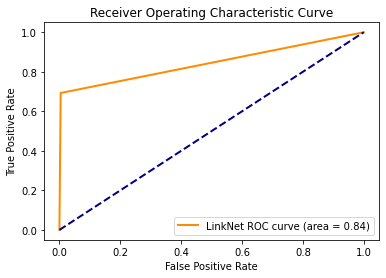

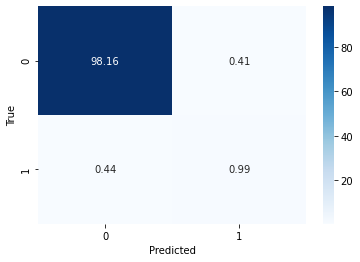

In [208]:
# Precision
linknet_precision = precision_score(y_test.flatten(), linknet_y_pred.flatten())
print(f'LinkNet Precision: {linknet_precision}')

# Average Precision
linknet_average_precision = average_precision_score(y_test.flatten(), linknet_y_pred.flatten())
print(f'LinkNet Average Precision: {linknet_average_precision}')

# Recall
linknet_recall = recall_score(y_test.flatten(), linknet_y_pred.flatten())
print(f'LinkNet Recall: {linknet_recall}')

# F1 Score
linknet_f1 = f1_score(y_test.flatten(), linknet_y_pred.flatten())
print(f'LinkNet F1 Score: {linknet_f1}')

# Intersection over Union (IoU)
linknet_intersection = np.logical_and(y_test.flatten(), linknet_y_pred.flatten())
linknet_union = np.logical_or(y_test.flatten(), linknet_y_pred.flatten())
linknet_iou = np.sum(linknet_intersection) / np.sum(linknet_union)
print(f'LinkNet Intersection over Union (IoU): {linknet_iou}')

# Receiver Operating Characteristic (ROC) Curve and AUC
linknet_fpr, linknet_tpr, linknet_thresholds = roc_curve(y_test.flatten(), linknet_y_pred.flatten())
linknet_roc_auc = auc(linknet_fpr, linknet_tpr)

plt.figure()
plt.plot(linknet_fpr, linknet_tpr, color='darkorange', lw=2, 
             label=f'LinkNet ROC curve (area = {linknet_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with percentages
linknet_cm = confusion_matrix(y_test.flatten(), linknet_y_pred.flatten())
linknet_total = np.sum(linknet_cm)
linknet_percentages = linknet_cm / linknet_total * 100

sns.heatmap(linknet_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



FCN Precision: 0.6854542650007712
FCN Average Precision: 0.485874462310297
FCN Recall: 0.70262150966069
FCN F1 Score: 0.6939317280364783
FCN Intersection over Union (IoU): 0.5313135177789999


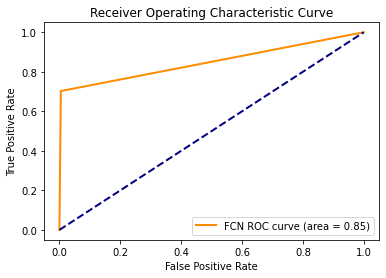

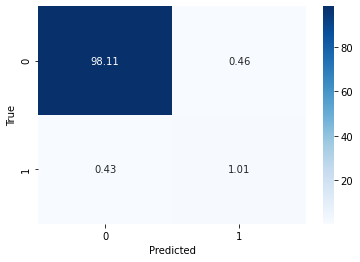

In [209]:
# Precision
fcn_precision = precision_score(y_test.flatten(), fcn_y_pred.flatten())
print(f'FCN Precision: {fcn_precision}')

# Average Precision
fcn_average_precision = average_precision_score(y_test.flatten(), fcn_y_pred.flatten())
print(f'FCN Average Precision: {fcn_average_precision}')

# Recall
fcn_recall = recall_score(y_test.flatten(), fcn_y_pred.flatten())
print(f'FCN Recall: {fcn_recall}')

# F1 Score
fcn_f1 = f1_score(y_test.flatten(), fcn_y_pred.flatten())
print(f'FCN F1 Score: {fcn_f1}')

# Intersection over Union (IoU)
fcn_intersection = np.logical_and(y_test.flatten(), fcn_y_pred.flatten())
fcn_union = np.logical_or(y_test.flatten(), fcn_y_pred.flatten())
fcn_iou = np.sum(fcn_intersection) / np.sum(fcn_union)
print(f'FCN Intersection over Union (IoU): {fcn_iou}')

# Receiver Operating Characteristic (ROC) Curve and AUC
fcn_fpr, fcn_tpr, fcn_thresholds = roc_curve(y_test.flatten(), fcn_y_pred.flatten())
fcn_roc_auc = auc(fcn_fpr, fcn_tpr)

plt.figure()
plt.plot(fcn_fpr, fcn_tpr, color='darkorange', lw=2, 
             label=f'FCN ROC curve (area = {fcn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with percentages
fcn_cm = confusion_matrix(y_test.flatten(), fcn_y_pred.flatten())
fcn_total = np.sum(fcn_cm)
fcn_percentages = fcn_cm / fcn_total * 100

sns.heatmap(fcn_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


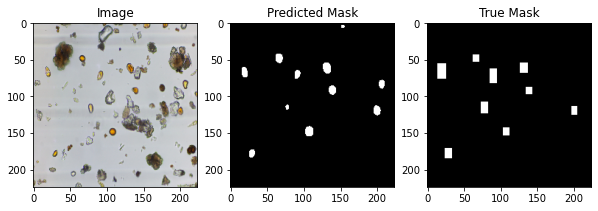

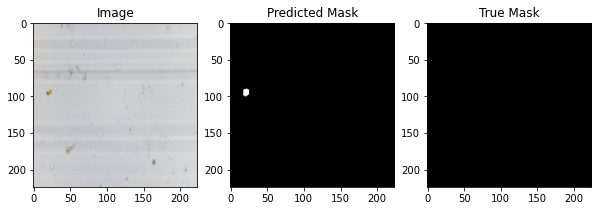

In [180]:
# Visualize the predicted masks 
for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(unet_y_pred[i], cmap='gray')
    plt.title("Predicted Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i], cmap='gray')
    plt.title("True Mask")
    plt.show()


In [181]:
def find_bounding_boxes(binary_mask):
    # Convert the binary mask to the correct data type
    binary_mask = binary_mask.astype(np.uint8)
    
    # Find connected components in the binary mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    bounding_boxes = []

    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        
        # Skip small regions 
        if area < min_area:
            continue

        # Create a bounding box (x_min, y_min, x_max, y_max)
        bounding_box = (x, y, x + w, y + h)
        bounding_boxes.append(bounding_box)

    return bounding_boxes

# Define the minimum area for a bounding box
min_area = 20  

unet_predicted_bounding_boxes=[]

for i in range(len(y_pred)):
    unet_binary_mask = unet_y_pred[i]
    # Find bounding boxes in the binary mask
    unet_predicted_bounding_boxes.append(find_bounding_boxes(unet_binary_mask))
    
segnet_predicted_bounding_boxes=[]

for i in range(len(y_pred)):
    segnet_binary_mask = segnet_y_pred[i]
    # Find bounding boxes in the binary mask
    segnet_predicted_bounding_boxes.append(find_bounding_boxes(segnet_binary_mask))
    
linknet_predicted_bounding_boxes=[]

for i in range(len(y_pred)):
    linknet_binary_mask = linknet_y_pred[i]
    # Find bounding boxes in the binary mask
    linknet_predicted_bounding_boxes.append(find_bounding_boxes(linknet_binary_mask))
    
fcn_predicted_bounding_boxes=[]

for i in range(len(y_pred)):
    fcn_binary_mask = fcn_y_pred[i]
    # Find bounding boxes in the binary mask
    fcn_predicted_bounding_boxes.append(find_bounding_boxes(fcn_binary_mask))

    

actual_bounding_boxes=[]

for i in range(len(y_test)):
    binary_mask = y_test[i]
    # Find bounding boxes in the binary mask
    actual_bounding_boxes.append(find_bounding_boxes(binary_mask))


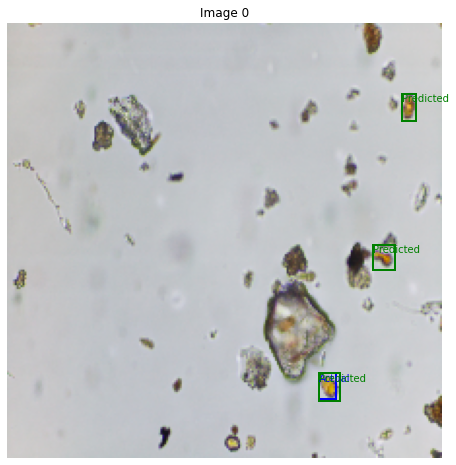

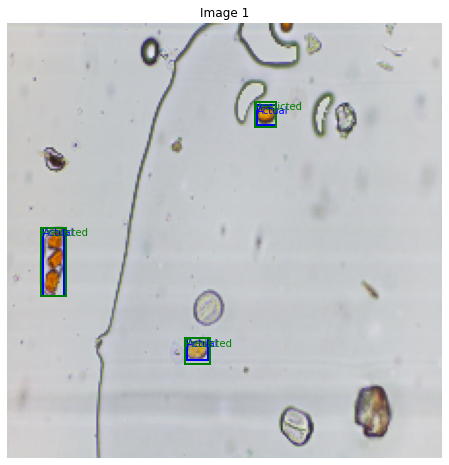

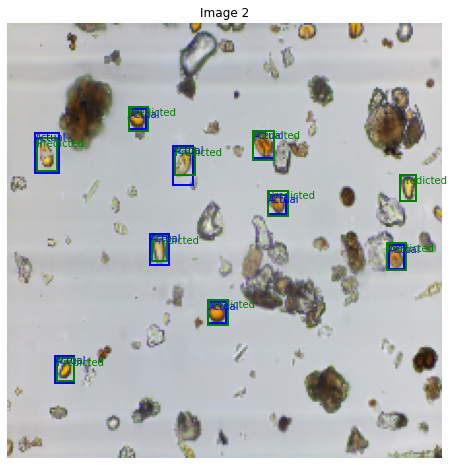

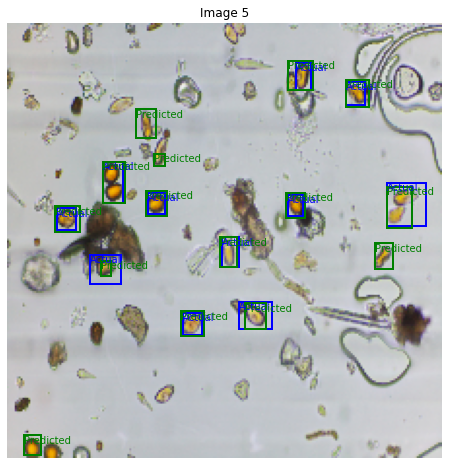

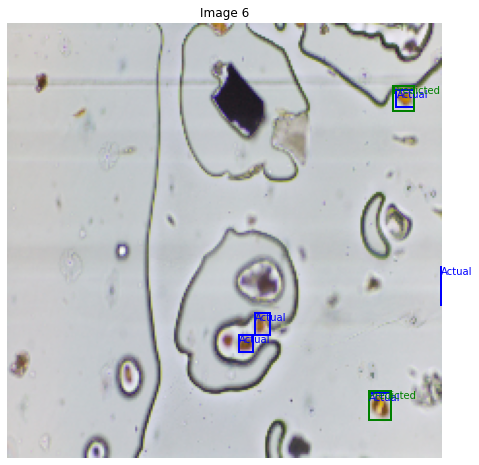

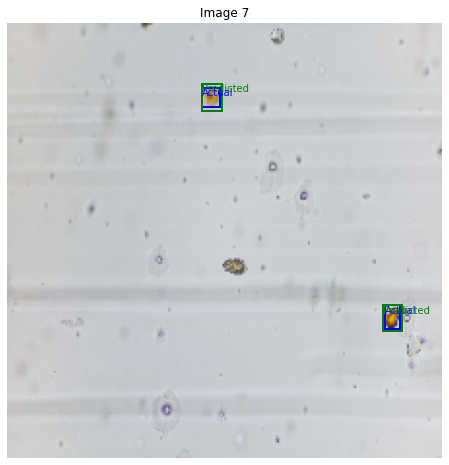

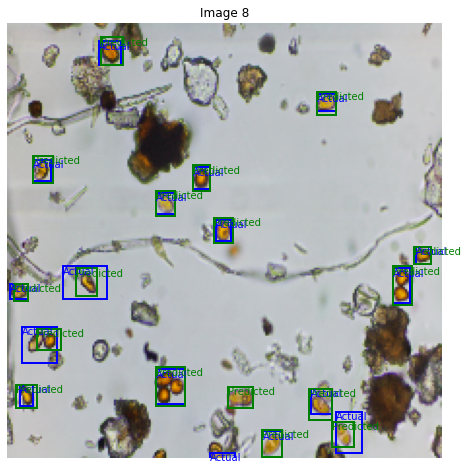

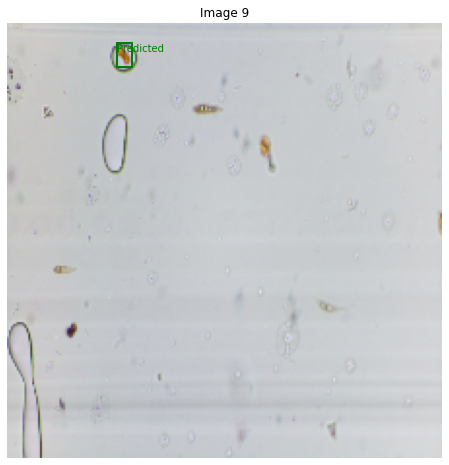

In [183]:
def draw_bounding_boxes_on_image(image, bounding_boxes, color, label):

    plt.imshow(image)
    ax = plt.gca()
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        rect = plt.Rectangle(
            (x_min, y_min), width, height, fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        plt.text(x_min, y_min, label, color=color, verticalalignment='top')

# Iterate through a few images in X_test and draw the bounding boxes

for i in range(10):
    image = X_test[i]  # Get the image
    actual_bbox = actual_bounding_boxes[i]  
    predicted_bbox = fcn_predicted_bounding_boxes[i]  

    plt.figure(figsize=(8, 8))
    draw_bounding_boxes_on_image(image, actual_bbox, 'blue', 'Actual')
    draw_bounding_boxes_on_image(image, predicted_bbox, 'green', 'Predicted')
    plt.title(f'Image {i}')
    plt.axis('off')
    plt.show()


Ensemble1 Precision: 0.7203628705653653
Ensemble1 Average Precision: 0.5107369008842597
Ensemble1 Recall: 0.7030958479587642
Ensemble1 F1 Score: 0.7116246319293305
Ensemble1 Intersection over Union (IoU): 0.5523426243354698


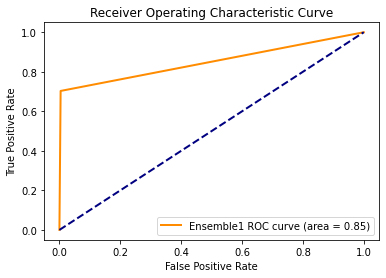

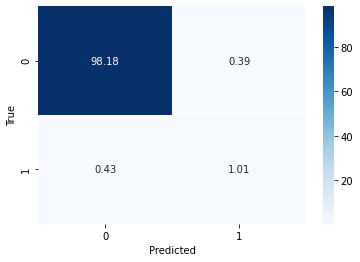

In [275]:
#Ensemble method 1: Model Averaging

# getting the predicted masks
unet_y_pred = unet_model.predict(X_test)
unet_y_pred=np.reshape(unet_y_pred,(44, 224, 224))

segnet_y_pred = segnet_model.predict(X_test)
segnet_y_pred=np.reshape(segnet_y_pred,(44, 224, 224))

linknet_y_pred = linknet_model.predict(X_test)
linknet_y_pred=np.reshape(linknet_y_pred,(44, 224, 224))

fcn_y_pred = fcn_model.predict(X_test)
fcn_y_pred=np.reshape(fcn_y_pred,(44, 224, 224))

ensemble1_y_pred = ((unet_y_pred + segnet_y_pred + linknet_y_pred + fcn_y_pred) / 4)


#finding the threshold to balance the number of ones


ensemble1_threshold = find_best_threshold(y_test,ensemble1_y_pred)


# Thresholding to obtain binary masks 
for i in range(len(unet_y_pred)):
    ensemble1_y_pred[i]=(ensemble1_y_pred[i] > ensemble1_threshold).astype(int)



# Flatten the arrays if needed
y_test_flat = y_test.flatten()
ensemble1_y_pred_flat = ensemble1_y_pred.flatten()

# Precision
ensemble1_precision = precision_score(y_test_flat, ensemble1_y_pred_flat)
print(f'Ensemble1 Precision: {ensemble1_precision}')

# Average Precision
ensemble1_average_precision = average_precision_score(y_test_flat, ensemble1_y_pred_flat)
print(f'Ensemble1 Average Precision: {ensemble1_average_precision}')

# Recall
ensemble1_recall = recall_score(y_test_flat, ensemble1_y_pred_flat)
print(f'Ensemble1 Recall: {ensemble1_recall}')

# F1 Score
ensemble1_f1 = f1_score(y_test_flat, ensemble1_y_pred_flat)
print(f'Ensemble1 F1 Score: {ensemble1_f1}')

# Intersection over Union (IoU)
ensemble1_intersection = np.logical_and(y_test_flat, ensemble1_y_pred_flat)
ensemble1_union = np.logical_or(y_test_flat, ensemble1_y_pred_flat)
ensemble1_iou = np.sum(ensemble1_intersection) / np.sum(ensemble1_union)
print(f'Ensemble1 Intersection over Union (IoU): {ensemble1_iou}')

# Receiver Operating Characteristic (ROC) Curve and AUC
ensemble1_fpr, ensemble1_tpr, ensemble1_thresholds = roc_curve(y_test_flat, ensemble1_y_pred_flat)
ensemble1_roc_auc = auc(ensemble1_fpr, ensemble1_tpr)

plt.figure()
plt.plot(ensemble1_fpr, ensemble1_tpr, color='darkorange', lw=2, 
             label=f'Ensemble1 ROC curve (area = {ensemble1_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with percentages
ensemble1_cm = confusion_matrix(y_test_flat, ensemble1_y_pred_flat)
ensemble1_total = np.sum(ensemble1_cm)
ensemble1_percentages = ensemble1_cm / ensemble1_total * 100

sns.heatmap(ensemble1_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [244]:
#Ensemble method 2: Stacking

# getting the predicted masks
unet_y_pred = unet_model.predict(X_test)
unet_y_pred=np.reshape(unet_y_pred,(44, 224, 224))

segnet_y_pred = segnet_model.predict(X_test)
segnet_y_pred=np.reshape(segnet_y_pred,(44, 224, 224))

linknet_y_pred = linknet_model.predict(X_test)
linknet_y_pred=np.reshape(linknet_y_pred,(44, 224, 224))

fcn_y_pred = fcn_model.predict(X_test)
fcn_y_pred=np.reshape(fcn_y_pred,(44, 224, 224))
    

# Create a stacked dataset
stacked_X_train = np.stack([unet_y_pred, segnet_y_pred, linknet_y_pred, fcn_y_pred], axis=-1)


# Define a meta-model (e.g., logistic regression)
meta_model = LogisticRegression()

# Train the meta-model on the stacked dataset
meta_model.fit(stacked_X_train.reshape((-1, 4)), y_test.reshape(-1))

# Make predictions using individual models
unet_pred_flat = unet_y_pred.reshape(-1)
segnet_pred_flat = segnet_y_pred.reshape(-1)
linknet_pred_flat = linknet_y_pred.reshape(-1)
fcn_pred_flat = fcn_y_pred.reshape(-1)

# Stack predictions for meta-model
stacked_X_test = np.column_stack([unet_pred_flat, segnet_pred_flat, linknet_pred_flat, fcn_pred_flat])

# Make predictions using the meta-model
ensemble_pred_stacked = meta_model.predict_proba(stacked_X_test)[:, 1]
ensemble2_y_pred = ensemble_pred_stacked.reshape((44, 224, 224))

#finding the threshold to balance the number of ones

ensemble2_threshold = find_best_threshold(y_test,ensemble2_y_pred)

# Thresholding to obtain binary masks 
for i in range(len(unet_y_pred)):
    ensemble2_y_pred[i]=(ensemble2_y_pred[i] > ensemble2_threshold).astype(int)



Ensemble2 Precision: 0.7148552721143561
Ensemble2 Average Precision: 0.5028770636754242
Ensemble2 Recall: 0.697403788381874
Ensemble2 F1 Score: 0.7060217050292922
Ensemble2 Intersection over Union (IoU): 0.5456209797130134


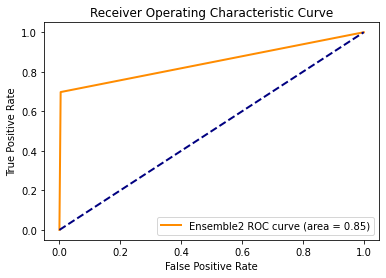

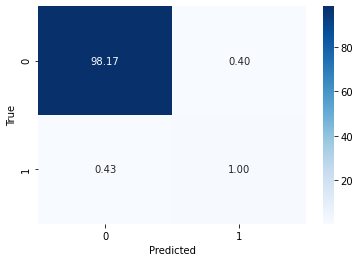

In [245]:
# Flatten the arrays if needed
y_test_flat = y_test.flatten()
ensemble2_y_pred_flat = ensemble2_y_pred.flatten()

# Precision
ensemble2_precision = precision_score(y_test_flat, ensemble2_y_pred_flat)
print(f'Stacking Precision: {ensemble2_precision}')

# Average Precision
ensemble2_average_precision = average_precision_score(y_test_flat, ensemble2_y_pred_flat)
print(f'Stacking Average Precision: {ensemble2_average_precision}')

# Recall
ensemble2_recall = recall_score(y_test_flat, ensemble2_y_pred_flat)
print(f'Stacking Recall: {ensemble2_recall}')

# F1 Score
ensemble2_f1 = f1_score(y_test_flat, ensemble2_y_pred_flat)
print(f'Stacking F1 Score: {ensemble2_f1}')

# Intersection over Union (IoU)
ensemble2_intersection = np.logical_and(y_test_flat, ensemble2_y_pred_flat)
ensemble2_union = np.logical_or(y_test_flat, ensemble2_y_pred_flat)
ensemble2_iou = np.sum(ensemble2_intersection) / np.sum(ensemble2_union)
print(f'Stacking Intersection over Union (IoU): {ensemble2_iou}')

# Receiver Operating Characteristic (ROC) Curve and AUC
ensemble2_fpr, ensemble2_tpr, ensemble2_thresholds = roc_curve(y_test_flat, ensemble2_y_pred_flat)
ensemble2_roc_auc = auc(ensemble2_fpr, ensemble2_tpr)

plt.figure()
plt.plot(ensemble2_fpr, ensemble2_tpr, color='darkorange', lw=2, 
             label=f'Stacking ROC curve (area = {ensemble2_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with percentages
ensemble2_cm = confusion_matrix(y_test_flat, ensemble2_y_pred_flat)
ensemble2_total = np.sum(ensemble2_cm)
ensemble2_percentages = ensemble2_cm / ensemble2_total * 100

sns.heatmap(ensemble2_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()